# Quantum Classification

The idea is to work with quantum classification tasks, for the thesis.

## Imports

In [1]:
from qiskit.version import get_version_info
print(get_version_info())

0.25.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [3]:
# For EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit.algorithms.optimizers import L_BFGS_B


In [4]:
# For Quantum Convolution Neural Network
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

In [5]:
# For dataset.
from sklearn.datasets import make_multilabel_classification

In [6]:
# for data split
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 123

In [7]:
# for classical computing
from sklearn.svm import SVC

In [8]:
# For Sampling
from qiskit.primitives import Sampler

## Dataset

In [27]:
# generate fake data
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=10000,
    n_features=2,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)

In [28]:
X.shape, y.shape

((10000, 2), (10000,))

In [29]:
y[:5]

array([2, 0, 0, 0, 1])

In [30]:
np.sum(y, axis=0)

9984

In [31]:
## Train test split
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

## Building Quantum ML

In [32]:
num_features = X.shape[1]

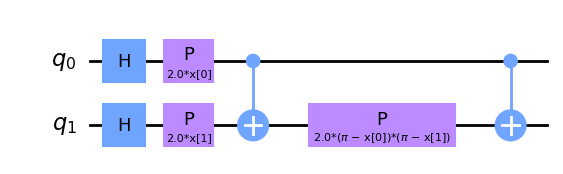

In [33]:
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

In [34]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
# ansatz.decompose().draw(output="mpl", fold=20)

There are 8 parameters, which are the trainable weights of the classifier.

In [35]:
# defining the optimiser
optimizer = COBYLA(maxiter=100)

Next we define to train our classifier. We use the instance of Sampler primitive.

In [36]:
sampler = Sampler()

In [37]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

VQC stands for variational quantum classifier. it takes the feature map and an ansatz and constructs a quantum neural network.

In [38]:
train_labels.shape

(8000,)

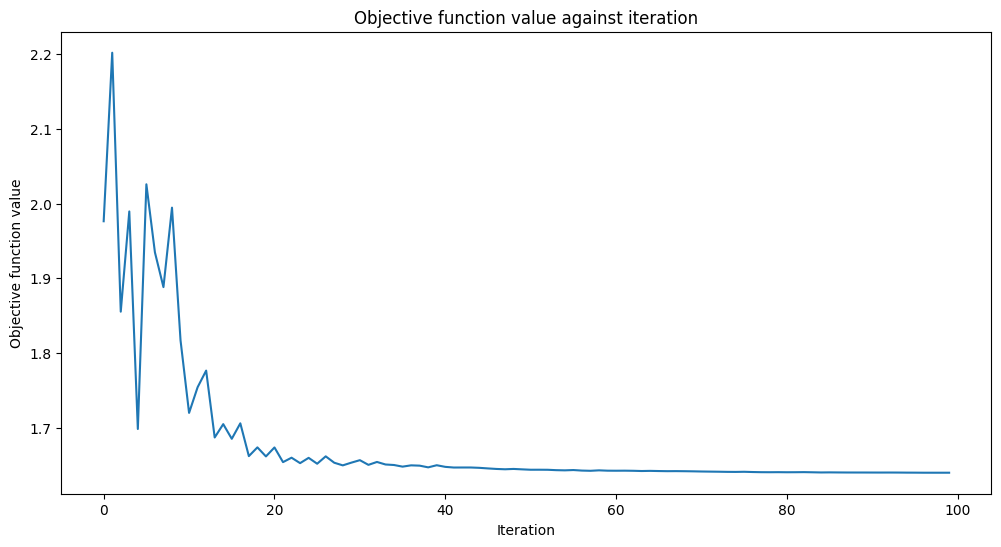

Training time: 751 seconds


In [39]:
vqc = VQC(
    # sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss='cross_entropy',
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [24]:
# testing the QSVC scores
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.34
Quantum VQC on the test dataset:     0.33


To scores are decent, to get better models:
1. The key components are feature map and the ansatz. The `reps` parameter that specifies how many repetitions of a gate pattern we add to the circuit. Larger values lead to more entanglement opearions and more parameters.
2. Changing the optimizers. Gradient based optimizer eg. L_BFGS_B increases the training time. Gradient based optimizer have to evaluate the gradient alongwidth the objective function, which leads to an increase number of circuit execution per iteration.
3. Another option is to sample initial_point and fit the model several times.

## Building SVC first (Classical side)

In [25]:
svc = SVC()
_ = svc.fit(train_features, train_labels)

In [26]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     1.00
